<a href="https://colab.research.google.com/github/hongqin/AI4Health/blob/main/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Genomics Primer (*Tutorial*)

This tutorial is a supplement to the manuscript, **A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. [Read the accompanying paper here](https://www.nature.com/articles/s41588-018-0295-5).

If you have any questions or feedback regarding this tutorial, please contact Abubakar Abid <<a12d@stanford.edu>> or James Zou <<jamesz@stanford.edu>>.

## Outline

* **How to Use This Tutorial**
* **0. Background**
* **1. Curate the Data**
* **2. Select the Architecture and Train**
* **3. Evaluate**
* **4. Interpret**

## How to Use This Tutorial

This tutorial utilizes a Colab notebook , which is an interactive computational enviroment that combines live code, visualizations, and explanatory text. To run this notebook, you may first need to make a copy by choosing **File > Save a Copy in Drive** from the menu bar (may take a few moments to save).

The notebook is organized into a series of cells. You can modify the Python command and execute each cell as you would a Jupyter notebook. To run all of the cells at once, choose **Runtime > Run all** from the menu bar.

## 0. Background

In this tutorial, we will show how to use deep learning to approach an important problem in functional genomics: **the discovery of transcription-factor binding sites in DNA**.

As we go through this notebook, we will  design a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our *independent variables* (or *predictors*), while the positive or negative response of the assay is the *dependent variable* (or *response*).

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(Spoiler alert: the true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural network doesn't know this.)


## 1. Curate the Data

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-01.png?raw=true)

In order to train the neural network, we must load and preprocess the data, which consists of DNA sequences and their corresponding labels.By processing this data, the network will learn to distinguish sequences that bind to the transcription factor from those that do not. We will split the data into three different sub-datasets:

(1) Training dataset: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

(2) Validation dataset: a second dataset used to minimize overfitting. The weights of the network are not adjusted with this data set. After each training cycle, if the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then there is overfitting on the neural network.

(3) Testing dataset: is a third dataset not included in the training nor validation data sets. After all the training and validation cycles are complete, this dataset is used only for testing the final solution in order to measure the actual predictive power of the neural network on new examples.

-----------

We start by loading the simulated data from an external repository.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


The next  step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors).

To get each DNA sequence in the form of a matrix, we use _one-hot encoding_, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In the cell below, we one-hot encode the simulated DNA sequences, and show an example of what the one-hot encoded sequence looks like:

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Similarly, we can go ahead and load the labels (_response variables_). In this case, the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features. We carry out that here:

In [ ]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. At a later step, we will further partition the training set into a training and validation set.

In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

## 2. Select the Architecture and Train

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)

Next, we choose a neural network architecture to train the model. In this tutorial, we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of a transcription factor binding site).

We will use the deep learning library `Keras`. As of 2017, `Keras` has been integrated into `TensorFlow`,  which makes it very easy to construct neural networks. We only need to specify the kinds of layers we would like to include in our network, and the dimensionality of each layer. The CNN we generate in this example consists of the following layers:

- _Conv1D_: We define our convolutional layer to have 32 filters of size 12 bases.

- _MaxPooling1D_: After the convolution, we use a pooling layer to down-sample the output of the each of the 32 convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters.

- _Dense_: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

We can see the details of the architecture of the neural network we have created by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in our network.

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12,
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 39, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,226 (24.32 KB)

 Trainable params: 6,226 (24.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#ChatGPT commented version
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

# Initialize a Sequential model using TensorFlow's Keras API
model = Sequential()

# Add a 1D Convolutional layer to the model.
# This layer will have 32 filters (neurons) and each filter will cover a span of 12 bases in the DNA sequence
# input_shape specifies the format or shape of the input data which in this case is the number of sequence positions (columns) and the one-hot encoding size (4 for the DNA bases)
model.add(Conv1D(filters=32, kernel_size=12,
                 input_shape=(train_features.shape[1], 4)))

# Add a MaxPooling layer, which will reduce the dimensionality of the sequence, effectively down-sampling the input representation.
# This layer picks the maximum value of each filter output within a pool_size window, in this case 4.
model.add(MaxPooling1D(pool_size=4))

# Add a Flatten layer, which transforms the format of the inputs into a single 1D vector. This layer is required for the input of Dense layers
model.add(Flatten())

# Add a Dense (fully-connected) layer to the model with 16 neurons and the ReLU activation function.
# ReLU function will output the input directly if it's positive, otherwise, it will output zero.
model.add(Dense(16, activation='relu'))

# Add a Dense layer with 2 neurons and the softmax activation function.
# This will be our output layer. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities.
# The model will then make its prediction based on which option has a higher probability.
model.add(Dense(2, activation='softmax'))

# Compile the model, specifying the loss function to be binary_crossentropy, which is appropriate for a binary classification problem,
# and the optimizer as 'adam', which is a common choice for neural networks.
# We also ask the model to compute accuracy as we train.
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])

# Print a summary of the model's architecture
model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 39, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,226 (24.32 KB)

 Trainable params: 6,226 (24.32 KB)

 Non-trainable params: 0 (0.00 B)

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

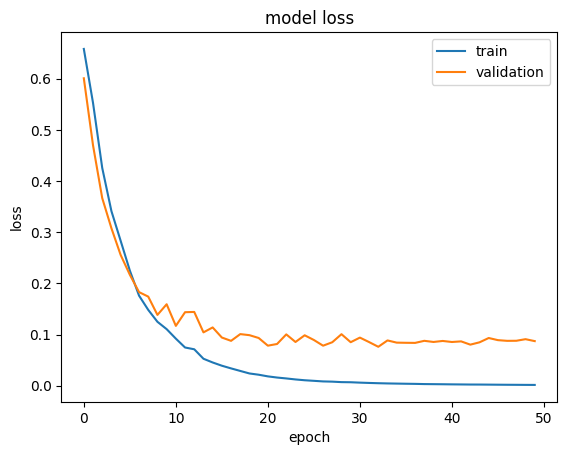

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Other metrics may be used in different tasks -- for example, the _mean squared error_ is typically used to measure the accuracy for continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight and systolic blood pressure).

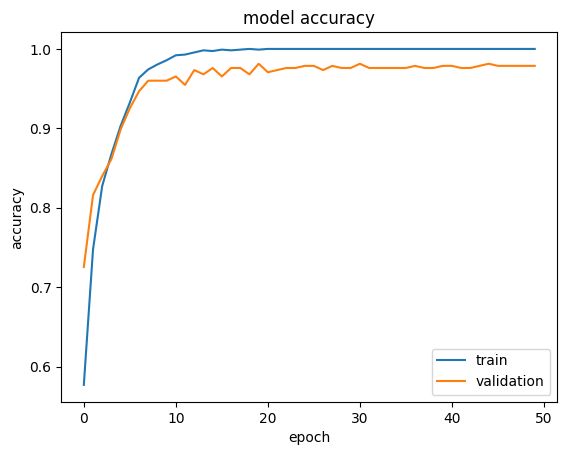

In [ ]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## 3. Evaluate

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix. Nearly every test sequence should be correctly classified.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Confusion matrix:
 [[255   4]
 [  1 240]]


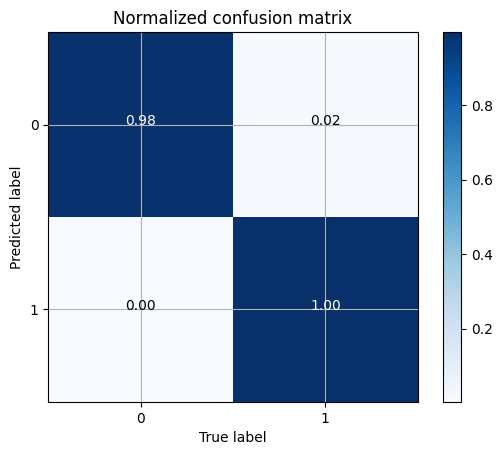

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1),
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

## 4. Interpret (Needs to be revised with SHAP index)

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-31.png?raw=true)

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But can we understand _why_ the neural network classifies a training point in the way that it does? To do so, we can compute a simple _saliency map_, which is the gradient of the model's prediction with respect to each individual nucleotide.

In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides form the binding motive that we are trying to identify.

## Acknowledgements

Thanks to Julia di lulio and Raquel Dias for helpful comments and suggestions in preparing this notebook.

# GitHub Repository

If you found this tutorial helpful, kindly star the [associated GitHub repo](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) so that it is more visible to others as well!

# Pytorch version

ref:
https://chatgpt.com/share/679443c7-a80c-800c-8d0a-aab47b5781dd

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)



Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a PyTorch neural network model
class Conv1DModel(nn.Module):
    def __init__(self, input_length):
        super(Conv1DModel, self).__init__()

        # 1D Convolutional layer with 32 filters and a kernel size of 12
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12)

        # MaxPooling layer with pool size of 4
        self.pool = nn.MaxPool1d(kernel_size=4)

        # Compute the size of the flattened feature vector after Conv1D and MaxPooling
        # Assuming input_length is the number of sequence positions
        self.flattened_size = ((input_length - 12 + 1) // 4) * 32

        # Fully connected layer with 16 neurons
        self.fc1 = nn.Linear(self.flattened_size, 16)

        # Fully connected output layer with 2 neurons
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        # Apply Conv1D -> ReLU activation -> MaxPooling
        x = self.pool(F.relu(self.conv1(x)))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layer -> ReLU activation
        x = F.relu(self.fc1(x))

        # Output layer with softmax activation
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Example usage:
# Assuming train_features is a tensor with shape (batch_size, num_positions, 4)
input_length = train_features.shape[1]
model = Conv1DModel(input_length=input_length)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # Equivalent to binary_crossentropy in PyTorch for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print the model architecture
print(model)


Conv1DModel(
  (conv1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
# Assuming the Conv1DModel class is already defined as above

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = Conv1DModel(input_length=train_features.shape[1]).to(device)

# Convert training data to PyTorch tensors and move them to the device
train_features_tensor = torch.tensor(train_features, dtype=torch.float32).permute(0, 2, 1).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)

# Create training and validation datasets
from torch.utils.data import DataLoader, random_split, TensorDataset

dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot the training and validation losses
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


RuntimeError: Expected floating point type for target with class probabilities, got Long

Epoch 1/50, Train Loss: 0.6861, Val Loss: 0.6713
Epoch 2/50, Train Loss: 0.6514, Val Loss: 0.6153
Epoch 3/50, Train Loss: 0.5659, Val Loss: 0.5210
Epoch 4/50, Train Loss: 0.4842, Val Loss: 0.4608
Epoch 5/50, Train Loss: 0.4348, Val Loss: 0.4290
Epoch 6/50, Train Loss: 0.4042, Val Loss: 0.4014
Epoch 7/50, Train Loss: 0.3855, Val Loss: 0.3877
Epoch 8/50, Train Loss: 0.3651, Val Loss: 0.3712
Epoch 9/50, Train Loss: 0.3521, Val Loss: 0.3623
Epoch 10/50, Train Loss: 0.3451, Val Loss: 0.3587
Epoch 11/50, Train Loss: 0.3403, Val Loss: 0.3513
Epoch 12/50, Train Loss: 0.3385, Val Loss: 0.3477
Epoch 13/50, Train Loss: 0.3325, Val Loss: 0.3441
Epoch 14/50, Train Loss: 0.3286, Val Loss: 0.3378
Epoch 15/50, Train Loss: 0.3256, Val Loss: 0.3354
Epoch 16/50, Train Loss: 0.3241, Val Loss: 0.3332
Epoch 17/50, Train Loss: 0.3230, Val Loss: 0.3316
Epoch 18/50, Train Loss: 0.3213, Val Loss: 0.3295
Epoch 19/50, Train Loss: 0.3204, Val Loss: 0.3289
Epoch 20/50, Train Loss: 0.3193, Val Loss: 0.3285
Epoch 21/

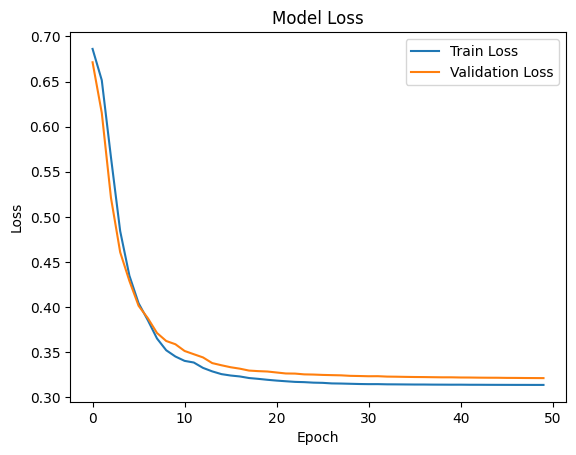

In [ ]:
# Assuming train_labels is one-hot encoded, convert it to class indices
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).argmax(dim=1).to(device)

# Rest of the code remains the same
dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot the training and validation losses
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## evaluate

Confusion matrix:
 [[259   0]
 [  0 241]]


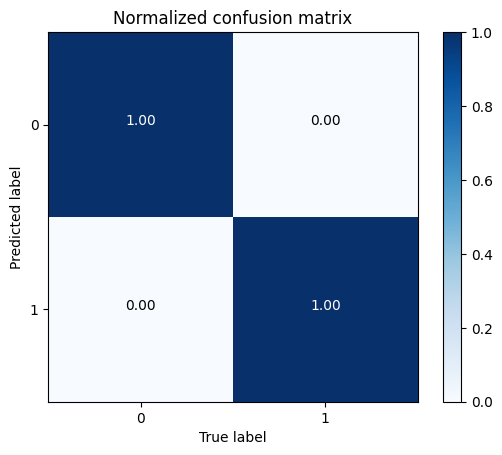

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Convert test features and labels to PyTorch tensors
test_features_tensor = torch.tensor(test_features, dtype=torch.float32).permute(0, 2, 1).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).argmax(dim=1).to(device)

# Get predictions
with torch.no_grad():
    outputs = model(test_features_tensor)
    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

# Compute confusion matrix
true_labels = test_labels_tensor.cpu().numpy()
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print('Confusion matrix:\n', cm)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)

# Annotate the confusion matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

plt.show()


# Transformer

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerClassifier(nn.Module):
    def __init__(self, input_length, num_classes=2, num_heads=4, num_layers=2, dim_feedforward=128):
        super(TransformerClassifier, self).__init__()
        self.input_length = input_length
        self.num_classes = num_classes

        # Linear embedding layer to project input (4 channels) into the transformer dimension
        self.embedding_dim = 64
        self.embedding = nn.Linear(4, self.embedding_dim)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, input_length, self.embedding_dim))

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.embedding_dim,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                batch_first=True
            ),
            num_layers=num_layers
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(self.embedding_dim * input_length, num_classes)

    def forward(self, x):
        # x shape: (batch_size, input_length, 4)

        # Apply embedding and add positional encoding
        x = self.embedding(x) + self.positional_encoding

        # Pass through the transformer
        x = self.transformer(x)

        # Flatten the output and pass through the final classification layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.softmax(x, dim=1)  # Softmax for probabilities


Epoch 1/50, Train Loss: 0.6167, Val Loss: 0.5801
Epoch 2/50, Train Loss: 0.5778, Val Loss: 0.5844
Epoch 3/50, Train Loss: 0.5589, Val Loss: 0.5931
Epoch 4/50, Train Loss: 0.5454, Val Loss: 0.5442
Epoch 5/50, Train Loss: 0.5282, Val Loss: 0.5728
Epoch 6/50, Train Loss: 0.5215, Val Loss: 0.5763
Epoch 7/50, Train Loss: 0.5151, Val Loss: 0.5728
Epoch 8/50, Train Loss: 0.5402, Val Loss: 0.5990
Epoch 9/50, Train Loss: 0.5213, Val Loss: 0.5621
Epoch 10/50, Train Loss: 0.5097, Val Loss: 0.5658
Epoch 11/50, Train Loss: 0.5218, Val Loss: 0.5704
Epoch 12/50, Train Loss: 0.5141, Val Loss: 0.6022
Epoch 13/50, Train Loss: 0.5128, Val Loss: 0.6055
Epoch 14/50, Train Loss: 0.5058, Val Loss: 0.5763
Epoch 15/50, Train Loss: 0.5185, Val Loss: 0.5775
Epoch 16/50, Train Loss: 0.5069, Val Loss: 0.5849
Epoch 17/50, Train Loss: 0.4978, Val Loss: 0.5865
Epoch 18/50, Train Loss: 0.4893, Val Loss: 0.5899
Epoch 19/50, Train Loss: 0.4904, Val Loss: 0.5953
Epoch 20/50, Train Loss: 0.4839, Val Loss: 0.5816
Epoch 21/

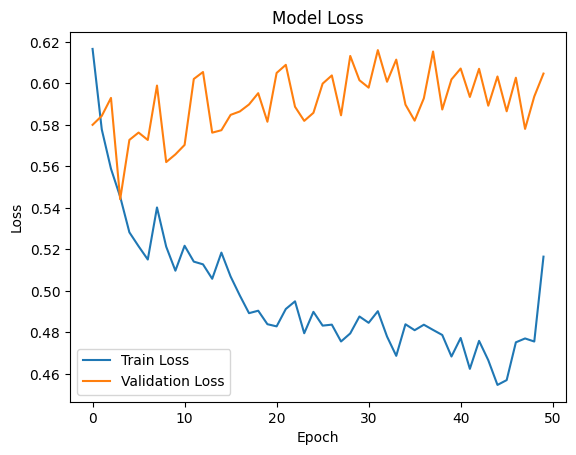

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Transformer model
model = TransformerClassifier(input_length=train_features.shape[1]).to(device)

# Convert data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).argmax(dim=1).to(device)

# Create datasets and data loaders
from torch.utils.data import DataLoader, random_split, TensorDataset

dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot the training and validation losses
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## evaluation

Confusion matrix:
 [[149 110]
 [ 54 187]]


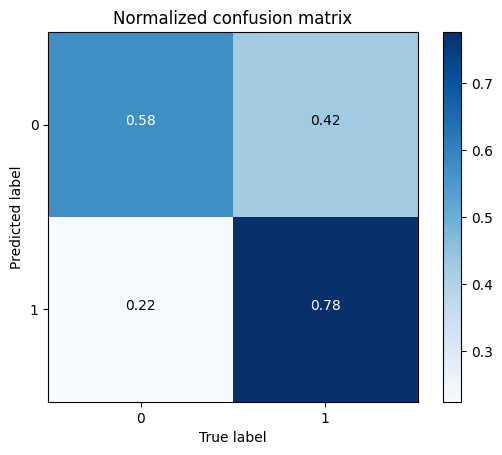

In [6]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Convert test features and labels to PyTorch tensors
test_features_tensor = torch.tensor(test_features, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).argmax(dim=1).to(device)

# Get predictions
with torch.no_grad():
    outputs = model(test_features_tensor)
    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

# Compute confusion matrix
true_labels = test_labels_tensor.cpu().numpy()
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print('Confusion matrix:\n', cm)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)

# Annotate the confusion matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

plt.show()
